In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from calendar import calendar

from streamflow_generation import multi_site_nile_generator, read_historical_series
from IPython.display import clear_output
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
from array import array

In [2]:
read_historical_series("BlueNile")

,Date,BlueNile_m3|s
0,1960-01-31,445.700000
1,1960-02-29,236.800000
2,1960-03-31,161.600000
3,1960-04-30,137.400000
4,1960-05-31,190.300000
...,...,...
451,1997-08-31,4606.481481
452,1997-09-30,2565.586420
453,1997-10-31,1990.740741
454,1997-11-30,1574.074074


In [3]:
catchments_1 = ["BlueNile", "WhiteNile", "Atbara"]
catchments_2 = ["Rahad", "Dinder"]

for realization in range(30):
    multi_site_nile_generator([catchments_1, catchments_2], 20, [realization, 100+realization], realization, "baseline")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try except
Just try

In [4]:
def divide_df(df, avgs, stds):
    
    flow = df.columns[-1]
    for i, row in df.iterrows():
        if stds[i % 12] != 0:
            df.loc[i, flow] = (df.loc[i, flow] - avgs[i%12]) / stds[i%12]
        else:
            df.loc[i, flow] = 0
        
    return df

def lognormalize_streamflows(streamflow_df):
    
    flow_name = streamflow_df.columns[-1]
    copy_df = streamflow_df.copy()
    
    # take logarithm
    problem_indices = copy_df[flow_name] < 1

    copy_df.loc[problem_indices,flow_name] = 1

    still_problem =copy_df.loc[copy_df[flow_name] < 1]
#     print(still_problem.to_markdown())
    copy_df[flow_name] = pd.Series(np.log(copy_df[flow_name]))
    monthly_averages = []
    monthly_std = []
    
    for i in range(0,12):
        month_obs = copy_df.loc[copy_df.index % 12 == i, flow_name]
        monthly_averages.append(np.mean(month_obs))
        monthly_std.append(np.std(month_obs))
    
    return divide_df(copy_df, monthly_averages, monthly_std)

def findDroughts(streamflow_df, plotting=False):
    
    flow_name = streamflow_df.columns[-1]
    dates = pd.Series(streamflow_df.index)
    normalized_log_streamflow = np.array(lognormalize_streamflows(streamflow_df)[flow_name])
    total_observations = len(normalized_log_streamflow)
    # first calculate the moving averages of 6 observations:

    numbers_series = pd.Series(normalized_log_streamflow)
    windows = numbers_series.rolling(6)
    moving_averages = windows.mean()
    # first 5 months will be NaN due to our window being 6, replace them with 0:
    moving_averages_list = moving_averages.fillna(0).tolist()

    # Now that we have the moving averages, let's apply the drought criterion:
    drought_period_indices = []

    for i in range(6, total_observations):
        section_of_six = moving_averages_list[i-6:i]
        if all(map(lambda x: x<0, section_of_six)) and any(map(lambda x: x<-1, section_of_six)):
            drought_period_indices.append(i)
            
    if plotting:
        plt.plot(dates, moving_averages_list, color='black')
        plt.vlines(x = [dates[x] for x in drought_period_indices], ymin=-2,
                 ymax = 2, colors = 'red')
        plt.xlabel('Date',fontsize=14)
        plt.ylabel('SSI$_6$', fontsize=14)
        plt.title(f"Drought investigation SSI6 criterion {flow_name}", fontsize=14)
        #plt.xticks(rotation='vertical', fontsize=18)
        plt.yticks(fontsize=14)
        plt.show()
    
    drought_groups = list()
    already_grouped = list()
    
    for i, dr_index in enumerate(drought_period_indices):
        if dr_index in already_grouped:
            continue
        current_group = [dr_index]
        j = i
        
        if not j == len(drought_period_indices)-1:
            while (drought_period_indices[j+1] - drought_period_indices[j] == 1):
                current_group.append(drought_period_indices[j+1])
                already_grouped.append(drought_period_indices[j+1])
                j += 1
                if j == len(drought_period_indices) - 1:
                    break
            
        drought_groups.append(current_group)
        
    drought_count = len(drought_groups)
    drought_magnitudes = list(map(lambda x: sum([moving_averages_list[i] for i in x]), drought_groups))
    avg_magnitude = np.nan_to_num(np.mean(drought_magnitudes))
    drought_lengths = list(map(lambda x: len(x), drought_groups))
    avg_duration = np.nan_to_num(np.mean(drought_lengths))
    
#     print(drought_groups)
            
    return drought_count, avg_magnitude, avg_duration

In [5]:
from datetime import datetime, timedelta
base = datetime(2023, 1, 1)
date_list = [base + timedelta(days=30.5*x) for x in range(240)]

In [6]:
fd = "../synthetic_hydrology/baseline/"
realizations = [file for file in os.listdir(fd) if file[-4:] == ".csv"]
drought_counts = []
average_durations = []
average_magnitudes = []

for file in realizations:
    print(file)
    full_df = pd.read_csv(fd + file)
    columns = full_df.columns
    full_df["Date"] = date_list
    drought_occurence = []
    magnitudes = []
    durations = []

    for catchment in columns:
        print(catchment)
        sub_data = full_df.loc[:,["Date", catchment]]
        drought_count, avg_magnitude, avg_duration = findDroughts(sub_data)
        #print(drought_count, avg_magnitude, avg_duration)
        drought_occurence.append(drought_count)
        magnitudes.append(avg_magnitude)
        durations.append(avg_duration)
        
    drought_counts.append(sum(drought_occurence))
    average_durations.append(np.average(durations, weights=drought_occurence))
    average_magnitudes.append(np.average(magnitudes, weights=drought_occurence))
#     print(drought_counts)
#     print(average_durations)
#     print(average_magnitudes)

6.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
7.csv

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



BlueNile
WhiteNile
Atbara
Rahad
Dinder
5.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
4.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
0.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
1.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
3.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
2.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
23.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
22.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
20.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
21.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
25.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
19.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
18.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
24.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
26.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
27.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
16.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
17.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
29.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
15.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder
14.csv
BlueNile
WhiteNile
Atbara
Rahad
Dinder


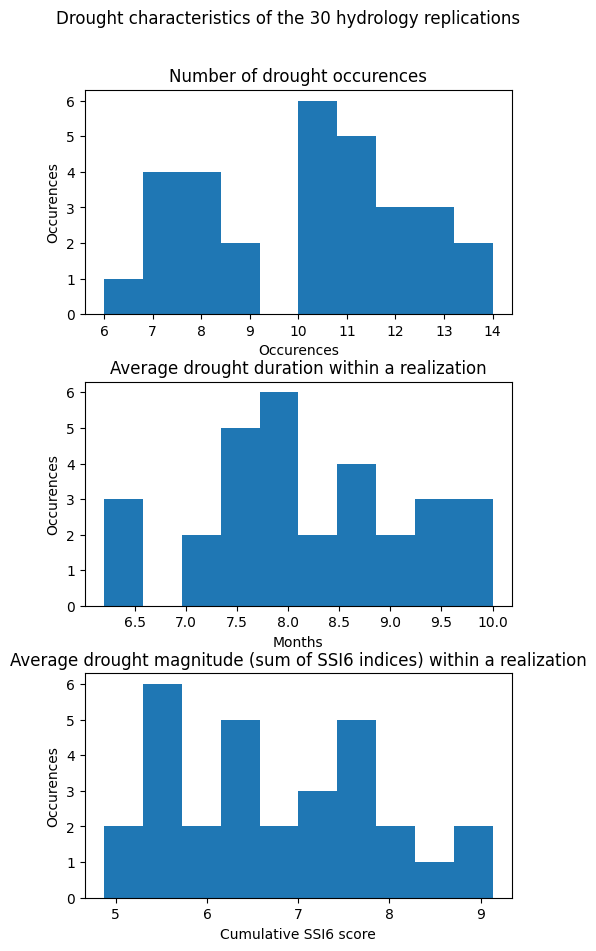

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,9))
fig.suptitle("Drought characteristics of the 30 hydrology replications", y=1.03)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
ax1.hist(drought_counts)
ax1.set_title("Number of drought occurences")
ax1.set_ylabel("Occurences")
ax1.set_xlabel("Occurences")
ax2.hist(average_durations)
ax2.set_title("Average drought duration within a realization")
ax2.set_ylabel("Occurences")
ax2.set_xlabel("Months")
ax3.hist([abs(i) for i in average_magnitudes])
ax3.set_title("Average drought magnitude (sum of SSI6 indices) within a realization")
ax3.set_ylabel("Occurences")
ax3.set_xlabel("Cumulative SSI6 score")
plt.show()